# On Designing a Machine Learning Based Wireless Link Quality Classifier

In this notebook, we will preproduce pipeline presented in

 - G. Cerar, H. Yetgin, M. Mohorčič and C. Fortuna, **"On Designing a Machine Learning Based Wireless Link Quality Classifier"**, *2020 IEEE 31st Annual International Symposium on Personal, Indoor and Mobile Radio Communications*, 2020, pp. 1-7, doi: 10.1109/PIMRC48278.2020.9217171 [[arXiv]](https://arxiv.org/abs/2007.02720)

 - G. Cerar, H. Yetgin, M. Mohorčič and C. Fortuna, **"Learning to Fairly Classify the Quality of Wireless Links"**, *2021 16th Annual Conference on Wireless On-demand Network Systems and Services Conference (WONS)*, 2021, pp. 1-8, doi: 10.23919/WONS51326.2021.9415540 [[arXiv]](https://arxiv.org/abs/2007.02720)

In [29]:
%reload_ext autoreload
%autoreload 2

import itertools as it
from typing import List, Tuple, Generator, Iterator
import multiprocess as mp # fix for macOS, use "multiprocessing" on linux

import numpy as np
import scipy as sp
from scipy import stats, optimize

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import sklearn as skl
from sklearn import base, ensemble, metrics, model_selection, preprocessing, tree, linear_model
from imblearn import metrics as imetrics
from imblearn import over_sampling, pipeline, under_sampling

from pprint import pprint
import joblib

SEED = 0xDEADBEEF
np.random.seed(SEED)
np.set_printoptions(suppress=True)

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('precision', 3)

#plt.style.use(['science', 'notebook'])

memory = joblib.Memory(location='.cache', verbose=0)

In [2]:
from datasets.trace1_Rutgers.transform import get_traces as load_rutgers, dtypes
from datasets.trace1_Rutgers import NOISE_SOURCES

In [43]:
labels = ['good', 'interm.', 'bad']

def prr_to_label(prr: float) -> str:
    if prr >= 0.9: return 'good'
    elif prr <= 0.1: return 'bad'
    return 'interm.'

TupleOrList = tuple([Tuple, List])

def interpolate_with_gaussian_noise(data: pd.Series) -> pd.Series:
    """Couldn't find a proper name. Very slow ..."""
    DTYPE = np.float32

    series = data.astype(DTYPE)
    values = series.tolist()
    processed = []

    series_size = len(values)

    prev_rssi = 0
    prev_seq = -1
    for seq, rssi in enumerate(values):
        if not np.isnan(rssi):
            avg_rssi = np.mean([prev_rssi, rssi])
            std_rssi = np.std([prev_rssi, rssi])
            std_rssi = std_rssi if std_rssi > 0 else np.nextafter(DTYPE(0), DTYPE(1))
            diff = seq - prev_seq - 1

            processed.extend(np.random.normal(avg_rssi, std_rssi, size=diff))
            processed.append(rssi)
            prev_seq, prev_rssi = seq, rssi

    avg_rssi = np.mean([prev_rssi, 0.])
    std_rssi = np.std([prev_rssi, 0.])
    diff = series_size - prev_seq - 1
    processed.extend(np.random.normal(avg_rssi, std_rssi, size=diff))

    series = pd.Series(data=processed, index=data.index, dtype=DTYPE)
    return series

def interpolate_with_constant(data: pd.Series, constant: int = 0) -> pd.Series:
    """Interpolate missing values with constant value."""
    return data.fillna(value=constant)

class CustomInterpolation(base.BaseEstimator, base.TransformerMixin):
    """Custom interpolation function to be used in"""
    
    STRATEGIES_ALL = ['none', 'gaussian', 'constant']

    def __init__(self, source:str, strategy:str='constant', constant:float=0, target=None):
        if strategy not in self.STRATEGIES_ALL:
            raise ValueError(f'"{strategy}" is not available strategy')

        self.strategy = strategy
        self.constant = constant

        self.source = source
        self.target = source if target is None else target


    def with_constant(self, data:pd.DataFrame) -> pd.DataFrame:
        df = data.copy()
        df[self.target] = df[self.source].fillna(value=self.constant)
        return df

    def with_gaussian(self, data:pd.DataFrame) -> pd.DataFrame:
        df = data.copy()
        df[self.target] = interpolate_with_gaussian_noise(df[self.source])
        return df
    
    def with_none(self, data:pd.DataFrame) -> pd.DataFrame:
        df = data.copy()
        src = [self.source] if isinstance(self.source, [str]) else self.source
        df = df.dropna(subset=src)
        return df

    def do_interpolation(self, X:pd.DataFrame) -> pd.DataFrame:
        if self.strategy == 'constant':
            return self.with_constant(X)

        if self.strategy == 'gaussian':
            return self.with_gaussian(X)
        
        if self.strategy == 'none':
            return self.with_none(X)

        raise ValueError(f'"{self.strategy}" is not available strategy')

    def fit(self, X: pd.DataFrame, y=None):
        return self

    def transform(self, X, y='deprecated', copy=True):
        if isinstance(X, (List, Tuple, )):
            with mp.Pool() as p:
                return p.map(self.do_interpolation, X)
        return self.do_interpolation(X)

    
class CustomSplitter(base.BaseEstimator, base.TransformerMixin):
    def __init__(self, X:TupleOrList=None, y:str='class', drop:TupleOrList=None):
        self.X = X
        self.y = y
        self.drop = drop

    def fit(self, X:pd.DataFrame, y=None):
        return self

    def transform(self, df: pd.DataFrame, y='deprecated', copy=True):
        df = df.copy() if copy else df
        if self.drop:
            df.drop(labels=self.drop, axis=1, inplace=True)

        if self.X:
            return df[self.X], df[self.y].ravel()

        return df.drop(self.y), df[self.y].ravel()
        
    
class CustomMerger(base.BaseEstimator, base.TransformerMixin):
    """Merge List of DataFrames"""

    def __init__(self):
        pass

    def fit(self, X: pd.DataFrame, y=None):
        return self

    def transform(self, X: pd.DataFrame, y='deprecated', copy=True):
        if isinstance(X, TupleOrList):
            return pd.concat(X, ignore_index=True).reset_index(drop=True)

        return X
    
class SyntheticFeatures(base.BaseEstimator, base.TransformerMixin):
    """Rolling window for mean & std features."""

    def __init__(self, source:str, window_size:int=10, target=None):
        self.source = source
        self.target = source if target is None else target

        if not isinstance(window_size, int) or not window_size > 0:
            raise ValueError(f'Window should be positive integer. Got `{window_size}` instead.')

        self.window = window_size

    def fit(self, X, y=None):
        return self

    def do_synthetics(self, data:pd.DataFrame) -> pd.DataFrame:
        df = data.copy()
        df[f'{self.target}_avg'] = df[self.source].rolling(self.window).mean()
        df[f'{self.target}_std'] = df[self.source].rolling(self.window).std()
        return df


    def transform(self, X: pd.DataFrame, y='deprecated', copy=True):
        if isinstance(X, (List, Tuple, )):
            with mp.Pool() as p:
                return p.map(self.do_synthetics, X)

        return self.do_synthetics(X)
    
    
class PRR(base.BaseEstimator, base.TransformerMixin):
    """Calculate PRR based on `target`"""

    def __init__(self, source:str, window_size:int, ahead:int, target:str='prr'):
        self.source = source
        self.target = source if target is None else target

        if not isinstance(window_size, int) or not window_size > 0:
            raise ValueError(f'window_size should be positive integer. Got `{window_size}` instead.')

        self.window = window_size

        if not isinstance(ahead, int) or not ahead >= 0:
            raise ValueError(f'ahead should be greater or equal to zero integer. Got `{ahead}` instead.')

        self.ahead = ahead

    def fit(self, X: pd.DataFrame, y=None):
        return self

    def calculate_prr(self, dataframe):
        df = dataframe.copy()
        df[self.target] = (df[self.source].astype(bool).rolling(self.window).sum() / self.window).shift(-1 * self.window * self.ahead)
        return df

    def transform(self, X: pd.DataFrame, y='deprecated'):
        if isinstance(X, TupleOrList):
            with mp.Pool() as p:
                return p.map(self.calculate_prr, X)

        return self.calculate_prr(X)
    
    

def poly_features(df: pd.DataFrame, include: List[str], degree: int, include_bias=False, *args, **kwargs) -> pd.DataFrame:
    """The `PolynomialFeatures` from sklern drops/loses information about column names from pandas, which is not very convinient.
    This is a workaround for this behaviour to preserve names.
    """
    X, excluded = df.loc[:, include], df.drop(include, axis=1)
    poly = preprocessing.PolynomialFeatures(degree=degree, include_bias=include_bias, *args, **kwargs).fit(X)

    # Next line converts back to pandas, while preserving column names
    X = pd.DataFrame(poly.transform(X), columns=poly.get_feature_names_out(X.columns), index=X.index)

    data = pd.concat([X, excluded], axis=1, )
    data = data.reset_index(drop=True)

    # Transform column names. Ex. 'rssi rssi_avg' -> 'rssi*rssi_avg'
    data = data.rename(lambda cname: cname.replace(' ', '*'), axis='columns')

    return data

def plot_confusion_matrix(y_true, y_pred, labels=labels):
    df_cm = metrics.confusion_matrix(y_true, y_pred, normalize='true', labels=labels)
    df_cm = pd.DataFrame(df_cm, index=labels, columns=labels)
    ax = sns.heatmap(df_cm, annot=True, vmin=0, vmax=1, annot_kws={"size": 16}, fmt='.3f', cmap='Blues') # font size
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    return ax

# The Impact of Cleaning & Interpolation 

In [37]:
features = ['rssi', 'rssi_std', 'rssi_avg']

dfs = []
for df in load_rutgers():
    df.loc[df['received'] == 0, 'rssi'] = np.nan
    dfs.append(df)
    
df = dfs

# TOGGLE: Helper class/function for interpolation. Supported strategies: 'none', 'gaussian', and 'constant'.
df = CustomInterpolation(source='rssi', strategy='constant', constant=0).fit_transform(df)

# Produces {source}_avg and {source}_std features
df = SyntheticFeatures(source='rssi', window_size=20).fit_transform(df)

# Produces PRR (packet received ratio).
df = PRR(source='received', window_size=20, ahead=1, target='prr').fit_transform(df)

# helper below merges list of dataframes of individual links into one giant dataset
df = CustomMerger().fit_transform(df)

# Produce labels for target value
df['target'] = df['prr'].apply(prr_to_label)

# Drop all invalid values (subset=[*features, 'target'])
df = df.dropna()

X, y = df[features].copy(), df['target'].ravel()


clf = pipeline.Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('resample', over_sampling.RandomOverSampler(random_state=SEED)),
    
    # Toggle between algorithms for estimation
    #('dtree', tree.DecisionTreeClassifier(max_depth=6, random_state=SEED)),
    ('logreg', linear_model.LogisticRegression(solver='lbfgs', multi_class='ovr', random_state=SEED)),
])

# This is used for cross-validation. Typically used when observing performance of algorithm
cv = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

y_pred = model_selection.cross_val_predict(clf, X, y, cv=cv, n_jobs=-1)

CustomInterpolation
SyntheticFeatures
PRR
Custom Merger
Pipeline
cv


In [38]:
print(imetrics.classification_report_imbalanced(y, y_pred, labels=labels))

                   pre       rec       spe        f1       geo       iba       sup

       good       1.00      0.95      1.00      0.97      0.97      0.94    645344
    interm.       0.54      0.91      0.96      0.67      0.93      0.87     55189
        bad       0.99      0.97      0.99      0.98      0.98      0.96    359127

avg / total       0.97      0.95      0.99      0.96      0.97      0.95   1059660



<AxesSubplot:>

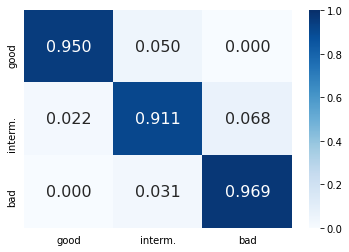

In [39]:
plot_confusion_matrix(y,y_pred)

# The Impact of feature Selection

Rutgers loaded ...
Interpolation applied ...
Synthetic features created ...
PRR created ...
Apply discrete derivation (backward difference)
Datasets merged ...
Classification applied ...
Drop useless features, drop lines with NaN
Polynomials applied ...
['rssi']


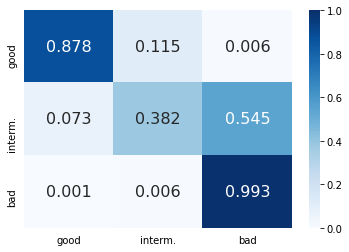

['rssi^2']


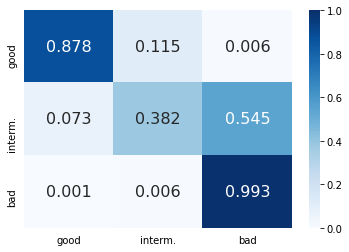

['rssi^3']


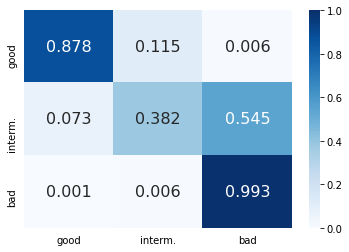

['rssi^4']


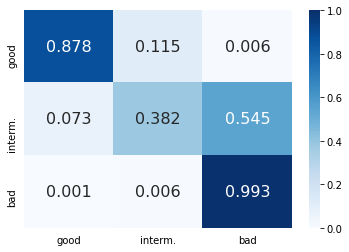

['rssi^-1']


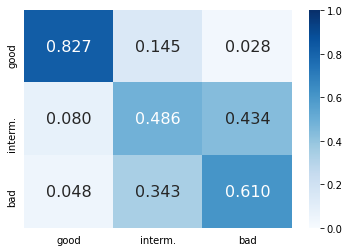

['rssi^-2']


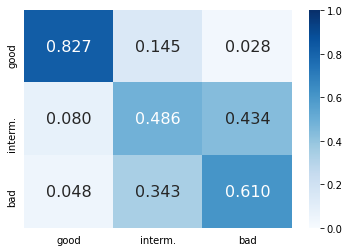

['rssi^-3']


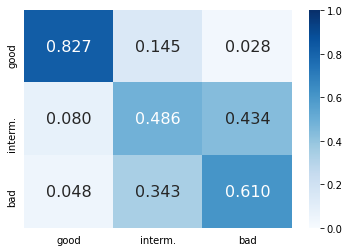

['rssi^-4']


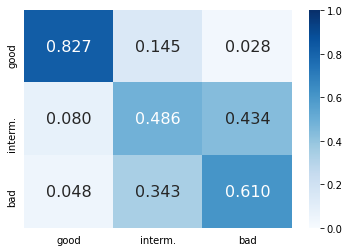

['rssi_avg']


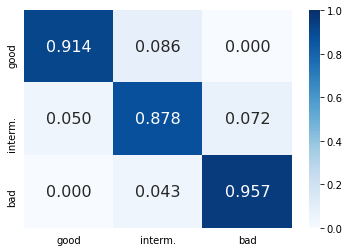

['rssi_avg^2']


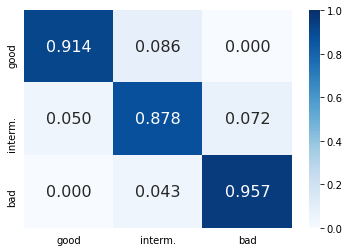

['rssi_avg^3']


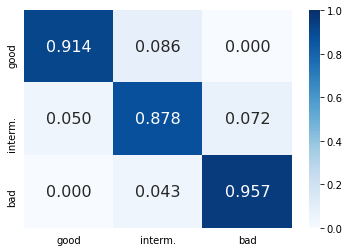

['rssi_avg^4']


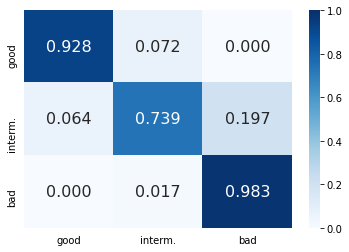

['rssi_avg^-1']


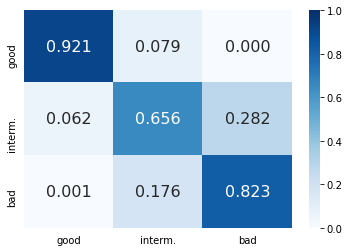

['rssi_avg^-2']


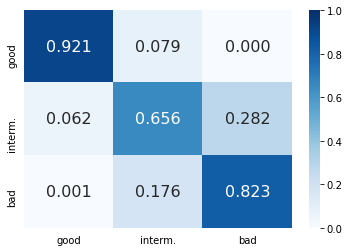

['rssi_avg^-3']


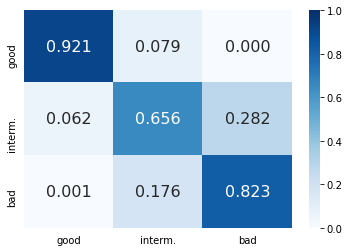

['rssi_avg^-4']


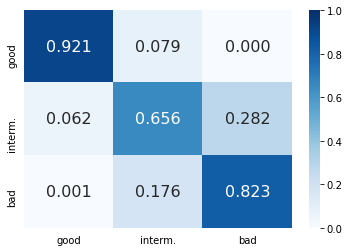

['rssi', 'rssi_avg']


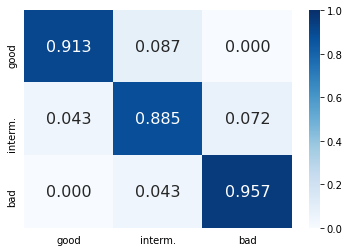

['rssi', 'rssi_std']


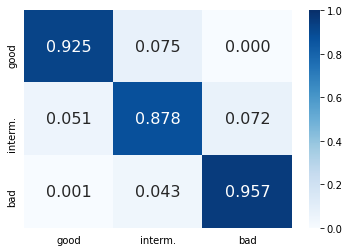

['rssi_avg', 'rssi_std']


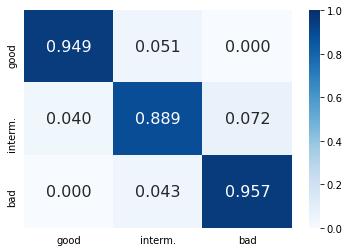

['rssi', 'rssi_avg', 'rssi_std']


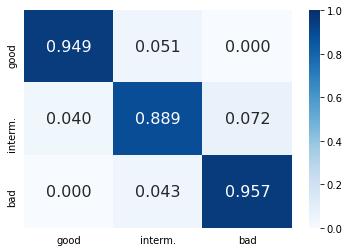

['rssi_avg', 'rssi_avg^2', 'rssi_avg^3', 'rssi_avg^4']


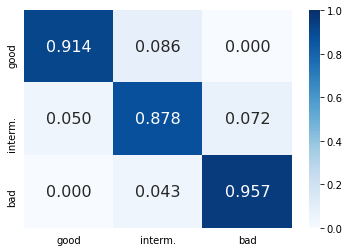

['rssi_avg', 'rssi_avg^-1', 'rssi_avg^-2', 'rssi_avg^-3', 'rssi_avg^-4']


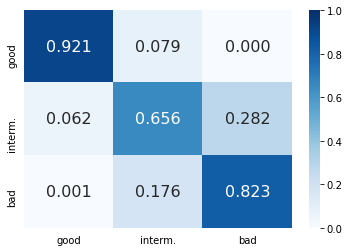

['rssi_avg', 'rssi_avg^2', 'rssi_avg^3', 'rssi_avg^4', 'rssi_avg^-1', 'rssi_avg^-2', 'rssi_avg^-3', 'rssi_avg^-4']


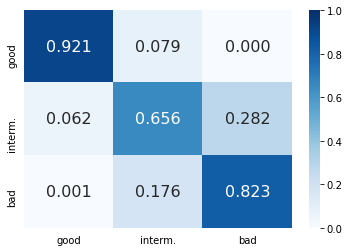

['drssi']


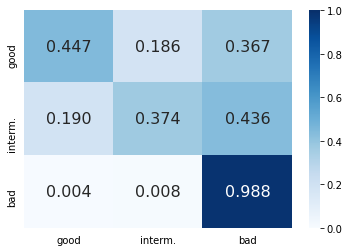

['rssi_std']


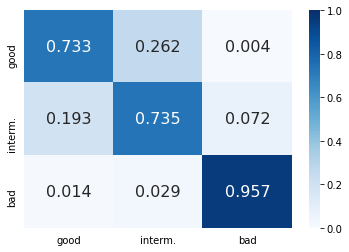

In [44]:
@memory.cache
def prepare_data():
    dataset = list(load_rutgers())
    print('Rutgers loaded ...')

    dataset = CustomInterpolation(source='rssi', strategy='constant', constant=0).fit_transform(dataset)
    print('Interpolation applied ...')

    dataset = SyntheticFeatures(source='rssi', window_size=10).fit_transform(dataset)
    print('Synthetic features created ...')

    dataset = PRR(source='received', window_size=10, ahead=1, target='prr').fit_transform(dataset)
    print('PRR created ...')

    print('Apply discrete derivation (backward difference)')
    for i in range(len(dataset)):
        dataset[i]['drssi'] = dataset[i]['rssi'].diff()

    dataset = CustomMerger().fit_transform(dataset)
    print('Datasets merged ...')

    dataset['class'] = dataset['prr'].apply(prr_to_label)
    print('Classification applied ...')


    dataset = dataset.dropna()
    dataset = dataset.drop(['noise', 'src', 'dst', 'received', 'prr'], axis=1)
    print('Drop useless features, drop lines with NaN')

    dataset = poly_features(dataset, include=['rssi', 'rssi_avg', 'rssi_std'], degree=4, include_bias=True)
    print('Polynomials applied ...')

    # Special synthetic features
    dataset['rssi^-1'] = 1. / dataset['rssi']
    dataset['rssi^-2'] = 1. / dataset['rssi^2']
    dataset['rssi^-3'] = 1. / dataset['rssi^3']
    dataset['rssi^-4'] = 1. / dataset['rssi^4']

    dataset['rssi_avg^-1'] = 1. / dataset['rssi_avg']
    dataset['rssi_avg^-2'] = 1. / dataset['rssi_avg^2']
    dataset['rssi_avg^-3'] = 1. / dataset['rssi_avg^3']
    dataset['rssi_avg^-4'] = 1. / dataset['rssi_avg^4']

    dataset['rssi_std^-1'] = 1. / dataset['rssi_std']
    dataset['rssi_std^-2'] = 1. / dataset['rssi_std^2']
    dataset['rssi_std^-3'] = 1. / dataset['rssi_std^3']
    dataset['rssi_std^-4'] = 1. / dataset['rssi_std^4']

    return dataset


feature_sets = [
    ['rssi'],
    ['rssi^2'],
    ['rssi^3'],
    ['rssi^4'],

    ['rssi^-1'],
    ['rssi^-2'],
    ['rssi^-3'],
    ['rssi^-4'],

    ['rssi_avg'],
    ['rssi_avg^2'],
    ['rssi_avg^3'],
    ['rssi_avg^4'],

    ['rssi_avg^-1'],
    ['rssi_avg^-2'],
    ['rssi_avg^-3'],
    ['rssi_avg^-4'],

    ['rssi', 'rssi_avg'],
    ['rssi', 'rssi_std'],
    ['rssi_avg', 'rssi_std'],
    ['rssi', 'rssi_avg', 'rssi_std'],

    ['rssi_avg', 'rssi_avg^2', 'rssi_avg^3', 'rssi_avg^4'],
    ['rssi_avg', 'rssi_avg^-1', 'rssi_avg^-2', 'rssi_avg^-3', 'rssi_avg^-4'],
    ['rssi_avg', 'rssi_avg^2', 'rssi_avg^3', 'rssi_avg^4', 'rssi_avg^-1', 'rssi_avg^-2', 'rssi_avg^-3', 'rssi_avg^-4'],
    ['drssi'],

    ['rssi_std'],

    # Every feature
    #[x[0] + x[1] for x in it.product(['rssi', 'rssi_avg', 'rssi_std'], ['^-4', '^-3', '^-2', '', '^-1', '^2', '^3', '^4'])]
]


pipe_logreg = pipeline.Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('resample', over_sampling.RandomOverSampler(random_state=SEED)),
    ('logistic', linear_model.LogisticRegression(solver='lbfgs', max_iter=1e3, multi_class='ovr', random_state=SEED)),
])

pipe_dtree = pipeline.Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('resample', over_sampling.RandomOverSampler(random_state=SEED)),
    ('DTree', tree.DecisionTreeClassifier(max_depth=4, random_state=SEED)),
])


@memory.cache
def different_features(pipe, features):
    dataset = prepare_data() ## cached
    
    # This is used for cross-validation. Typically used when observing performance of algorithm
    cv = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

    dataset = dataset.replace([np.inf, -np.inf], np.nan).dropna(subset=features)

    X, y = dataset.drop(['class'], axis=1), dataset['class'].ravel()

    y_pred = model_selection.cross_val_predict(pipe, X[features].values, y, cv=cv, n_jobs=-1)

    return y, y_pred



pipe = pipe_dtree

for features in feature_sets:
    y, y_pred = different_features(pipe, features)

    print(features)
    #print(metrics.classification_report(y, y_pred, labels=labels))
    plot_confusion_matrix(y, y_pred)
    plt.show()

# Impact of Resampling

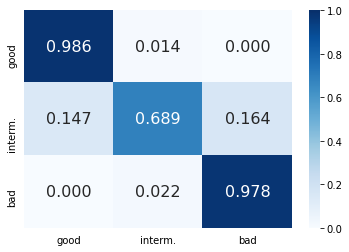

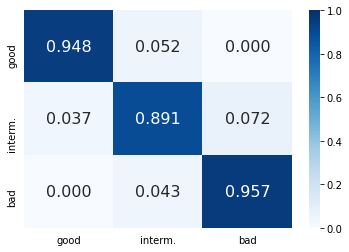

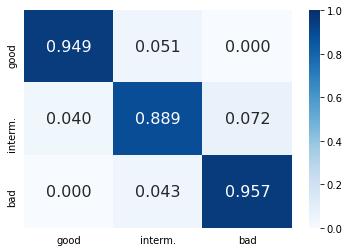

In [45]:
features = ['rssi', 'rssi_std', 'rssi_avg']

pipe_no_resample = pipeline.Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('dtree', tree.DecisionTreeClassifier(max_depth=4, random_state=SEED)),
])

pipe_oversample = pipeline.Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('resample', over_sampling.RandomOverSampler(random_state=SEED)),
    ('dtree', tree.DecisionTreeClassifier(max_depth=4, random_state=SEED)),
])

pipe_undersample = pipeline.Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('resample', under_sampling.RandomUnderSampler(random_state=SEED)),
    ('dtree', tree.DecisionTreeClassifier(max_depth=4, random_state=SEED)),
])

for estimator in (pipe_no_resample, pipe_undersample, pipe_oversample):
    df = prepare_data()
    
    # This is used for cross-validation. Typically used when observing performance of algorithm
    cv = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

    dataset = df.replace([np.inf, -np.inf], np.nan).dropna(subset=features)

    X, y = df.drop(['class'], axis=1), df['class'].ravel()

    y_pred = model_selection.cross_val_predict(estimator, X[features].values, y, cv=cv, n_jobs=-1)

    plot_confusion_matrix(y, y_pred, labels=labels)
    plt.show()

# The Impact of Model Selection

/usr/local/anaconda3/envs/lqe/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   pre       rec       spe        f1       geo       iba       sup

       good       0.00      0.00      1.00      0.00      0.00      0.00    697938
    interm.       0.00      0.00      1.00      0.00      0.00      0.00     52498
        bad       0.34      1.00      0.00      0.51      0.00      0.00    390424

avg / total       0.12      0.34      0.66      0.17      0.00      0.00   1140860



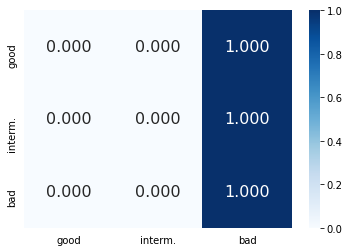

                   pre       rec       spe        f1       geo       iba       sup

       good       1.00      0.93      1.00      0.96      0.96      0.93    697938
    interm.       0.43      0.86      0.95      0.58      0.90      0.81     52498
        bad       0.98      0.97      0.99      0.98      0.98      0.96    390424

avg / total       0.97      0.94      0.99      0.95      0.97      0.93   1140860



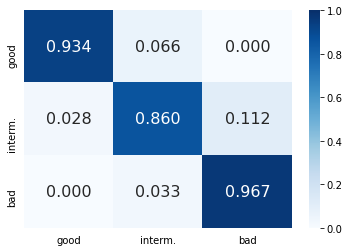

                   pre       rec       spe        f1       geo       iba       sup

       good       1.00      0.95      1.00      0.97      0.97      0.94    697938
    interm.       0.47      0.89      0.95      0.62      0.92      0.84     52498
        bad       0.99      0.96      0.99      0.97      0.98      0.95    390424

avg / total       0.97      0.95      0.99      0.96      0.97      0.94   1140860



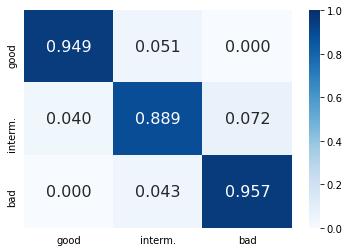

In [46]:
from sklearn import dummy

features = ['rssi', 'rssi_std', 'rssi_avg']

baseline = pipeline.Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('resample', over_sampling.RandomOverSampler(random_state=SEED)),
    ('dummy', dummy.DummyClassifier(random_state=SEED, constant='good')),
])

dtree = pipeline.Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('resample', over_sampling.RandomOverSampler(random_state=SEED)),
    ('dtree', tree.DecisionTreeClassifier(max_depth=4, random_state=SEED)),
])

logreg = pipeline.Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('resample', over_sampling.RandomOverSampler(random_state=SEED)),
    ('logreg', linear_model.LogisticRegression(random_state=SEED)),
])

for estimator in (baseline, logreg, dtree):
    df = prepare_data()
    
    # This is used for cross-validation. Typically used when observing performance of algorithm
    cv = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

    dataset = df.replace([np.inf, -np.inf], np.nan).dropna(subset=features)

    X, y = df.drop(['class'], axis=1), df['class'].ravel()

    y_pred = model_selection.cross_val_predict(estimator, X[features].values, y, cv=cv, n_jobs=-1)

    print(imetrics.classification_report_imbalanced(y, y_pred, labels=labels))
    plot_confusion_matrix(y, y_pred, labels=labels)
    plt.show()